In [2]:
import csv
import re
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
import pandas as pd

# from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
import seaborn

plt.style.context("seaborn-whitegrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
threshold = 1 # >1 considered to be amplification, <-1 considered to be deletion
amp_threshold = 0.25 
del_threshold = -0.25
arm_qvalue = 0.25 # qvalue < 0.25 is considered for a arm to be significantly amplified or deleted
num_tcga_patients = 177
num_htmcp_patients = 118
num_htmcp_hiv_pos_patients = 73
num_htmcp_hiv_neg_patients = 45

In [3]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'
# bindir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/'
# chr_accu_length_f = f'{wkdir}chromosome_accumulative_length.txt'
chromosomef = f'{wkdir}chromosome_coordinates.txt'

# # this removed germline cnvs
# tcga_cn_file = '/home/szong/bin/GISTIC_2_0_22/tcga/segmentationfile.txt'
# # tcga_cn_file is extracted from below minus_germline files downloaed from firebrowse
# # tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt'
# # tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broastart = 'cum_start'
end = 'cum_end'
# value = 'pct'dinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.seg.txt'
# tcga_core_sample_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/TCGA_178_core_samples.txt'
# htmcp_hiv_neg_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/segmentationfile.txt'
# htmcp_hiv_pos_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/segmentationfile.txt'
# # htmcp_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
hivpos_uniqamp_armsf = f'{wkdir}hivpos_uniqamp_arms_{arm_qvalue}.txt'
hivneg_uniqamp_armsf = f'{wkdir}hivneg_uniqamp_arms_{arm_qvalue}.txt'
hivpos_uniqdel_armsf = f'{wkdir}hivpos_uniqdel_arms_{arm_qvalue}.txt'
hivneg_uniqdel_armsf = f'{wkdir}hivneg_uniqdel_arms_{arm_qvalue}.txt'
tcga_uniqdel_armsf = f'{wkdir}tcga_uniqdel_arms_{arm_qvalue}.txt'
tcga_uniqamp_armsf = f'{wkdir}tcga_uniqamp_arms_{arm_qvalue}.txt'
hivneg2_uniqdel_armsf = f'{wkdir}hivneg2_uniqdel_arms_{arm_qvalue}.txt'
hivneg2_uniqamp_armsf = f'{wkdir}hivneg2_uniqamp_arms_{arm_qvalue}.txt'



In [4]:
f2_1 = '/home/szong/projects/resource/chrominfo.txt'
df2_1 = pd.read_csv(f2_1, sep='\t', usecols=['#chrom', 'size'])
df2_1['chr'] = df2_1['#chrom'].apply(lambda x: x.replace('chr', ''))
chr_sizes = df2_1.set_index('chr').drop('#chrom', axis=1)
chr_sizes = chr_sizes.reset_index().replace('X', '23').replace('Y', '24').iloc[:24,].set_index('chr')
chr_sizes.index = chr_sizes.index.astype(int)
chr_sizes = chr_sizes.sort_index()
chr_sizes.head(2)
# initiate occupied label coordinates dict
chr_length = chr_sizes['size']#.astype(str)
y_coords = np.arange(7, .5, -0.5)

,size
chr,
1,249250621
2,243199373


In [5]:
# plot baseline
start = 0
end = 0
# baseline = 1
vlns = []
mpnts = []
for ch, length in enumerate(chr_length[:-1]):
    ch+=1
    end+=length
    midpoint = (start + end)/2
    mpnts.append(midpoint)
#     _ = ax0.text(midpoint, 1, ch, ha='center')
    if ch %2 == 1:
        vlns.append(start)
        vlns.append(end)
#         _ = fill([start, end, end, start], [0, 0, 11, 11], 'b', alpha=0.1, edgecolor='b')
#         _= ax0.vlines(start, 0, 10, color='gray', linestyle='--', linewidth=.5)
#         _= ax0.vlines(end, 0, 10, color='gray', linestyle='--', linewidth=.5)
    start+=length
#     _ = ax0.text(midpoint, 1, ch, ha='center')


# chromosome arm coordinates
f = f'{wkdir}chromosome_arm_coordinates.txt'
arm_coords = pd.read_csv(f, sep='\t')
arm_coords[:2]

,chrom,arm,start,end,chr_arm
0,1,p,1,125000000,1p
1,1,q,125000001,249250621,1q


In [6]:
# unique arm level alterations


hivpos_uniqamp_arms = pd.read_csv(hivpos_uniqamp_armsf, header=None)[0].tolist()
hivpos_uniqamp_arms

hivneg_uniqamp_arms = pd.read_csv(hivneg_uniqamp_armsf, header=None)[0].tolist()
hivneg_uniqamp_arms

# no hivneg uniq del 
# hivneg_uniqdel_arms = pd.read_csv(hivneg_uniqdel_armsf, header=None)[0].tolist()
# hivneg_uniqdel_arms

hivpos_uniqdel_arms = pd.read_csv(hivpos_uniqdel_armsf, header=None)[0].tolist()
hivpos_uniqdel_arms

tcga_uniqdel_arms = pd.read_csv(tcga_uniqdel_armsf, header=None)[0].tolist()
tcga_uniqdel_arms

# no tcga uniqamp events
# tcga_uniqamp_arms = pd.read_csv(tcga_uniqamp_armsf, header=None)[0].tolist()
# tcga_uniqamp_arms

# hivneg2  
hivneg2_uniqdel_arms = pd.read_csv(hivneg2_uniqdel_armsf, header=None)[0].tolist()
hivneg2_uniqdel_arms

hivneg2_uniqamp_arms = pd.read_csv(hivneg2_uniqamp_armsf, header=None)[0].tolist()
hivneg2_uniqamp_arms

['6p', '16p', '14q', '9q', '16q', '9p']

['3p', '15q']

['13q', '5q', '21q', '4q']

['22q', '17p', '5q', '4q', '6q', '3q', '10q', '13q', '18q', '8p', '9p']

['21p']

['3p', '8p', '15q']

### use GISTIC all_data_by_genes.txtto show the magnitude of arm level alterations, we have broad_values_by_arm.txt file too. but can not figure out which patients are deemed to have arm level amplifications or deletions

In [7]:
chrdf = pd.read_csv(chromosomef)
chrdf.columns = ['start', 'end', 'chrom']
chrdf[:2]

,start,end,chrom
0,0,249250621.0,1
1,249250621,492449994.0,2


In [8]:
def plot_chromosomes(df, ax):
    # plot chromosome names


    # plot chromosomes rectangles
    chr_clrs = ['white' if i%2==0 else 'black' for i in df['chrom'] ]
    text_clrs = chr_clrs + ['white']
#     print(chr_clrs)
#     print(text_clrs)
    for ix, row in df.iterrows():
        chrom = int(row.chrom)
        start = row.start
        end = row.end

        _ = ax.add_patch(matplotlib.patches.Rectangle((start,0), end-start, 1.6,  
                                              edgecolor='gray', facecolor=chr_clrs[chrom-1], 
                                              alpha=1, linewidth=2))
        if chrom <= 23:
            _ = ax.text(int((start + end)/2), 0.6, chrom, ha='center', color=text_clrs[chrom])
        else:
            _ = ax.text(int((start + end)/2), 0.6, 'X', ha='center', color=text_clrs[chrom])
            

In [9]:
def gene_cumulative_coord(df1, df2):
    df3 = pd.merge(df1, df2, left_on='chrn', right_index=True)
    df3['cum_start'] = df3['cumulative_length'] + df3['start']
    df3['cum_end'] = df3['cumulative_length'] + df3['nd']
    df3 = df3[['chrn', 'symb', 'cum_start', 'cum_end']].set_index('symb')
    return df3
#     cols = ['start', 'nd', 'chrn', 'Gene Symbol', 'Locus ID', 'Cytoband', 'cumulative_length']
#     return df3.drop(cols, axis=1).sort_values('cum_start')
# gene_cumulative_coord(df1, df5)

In [10]:
def fraction_amplitude(df1, df2, alter_type, threshold, num_patients):
    if alter_type.lower() == 'del':
        df2 = df2 < threshold
    elif alter_type.lower() == 'amp':
        df2 = df2 > threshold
    else: print('wrong copy number alteration type!')
    df3 = df1 * df2
    df3['avg_amplitude'] = df3[df3 != 0].mean(axis=1)
    df3['fraction'] = df3[df3 != 0].count(axis=1) / num_patients
    df3 = df3[['avg_amplitude', 'fraction']]
    return df3
    
    

In [11]:
# gene cumulative coordinates
# use gistic refgenefile including both the cytoband and ref genes
f1 = '/projects/da_workspace/software/gistic/rg.txt'
df1 = pd.read_csv(f1)
df1.head(2)
df1 = df1.set_index(['chrn', 'start', 'nd'])
df1 = df1.loc[~df1.index.duplicated(keep='first')].reset_index()
df1 = df1[df1.chrn != 24]

f5 = '/home/szong/projects/resource/chromosome_accumulative_length.txt'
df5 = pd.read_csv(f5, sep='\t').drop(['chrom', 'length'], axis=1).set_index(np.arange(1,26, 1))
df5.head(2)
df_cum = gene_cumulative_coord(df1, df5)

# fracampl = fraction_amplitude(df1, df2, 'del', 0, 177)
# dfm = pd.merge(fracampl, df_cum, left_index=True, right_index=True, how='left')
# dfm = dfm.sort_values('cum_start')

,refseq,gene,symb,locus_id,chr,strand,start,nd,cds_start,cds_end,status,chrn
0,NM_000014,alpha-2-macroglobulin precursor,A2M,2,chr12,0,9220303,9268558,9220418,9268445,Reviewed,12
1,NM_000015,arylamine N-acetyltransferase 2,NAT2,10,chr8,1,18248754,18258723,18257513,18258386,Reviewed,8


,cumulative_length
1,0
2,249250621


In [12]:
def gene_df(f, pattern): 
    df = pd.read_csv(f, sep='\t', index_col= 'Gene Symbol')
    df = df[df.columns[df.columns.str.startswith(pattern)]]
    return df

In [13]:
def prep_cn(f1, f2, cn_type, threshold, num_patients, df_cum, pattern):
    df1 = gene_df(f1, pattern)
    df2 = gene_df(f2, pattern)
    fracampl = fraction_amplitude(df1, df2, cn_type, threshold, num_patients)
    dfm = pd.merge(fracampl, df_cum, left_index=True, right_index=True, how='left')
    dfm = dfm.sort_values('cum_start')
    return dfm

In [14]:
f1 = '/home/szong/bin/GISTIC_2_0_22/tcga/all_data_by_genes.txt'
f2 = '/home/szong/bin/GISTIC_2_0_22/tcga/all_thresholded.by_genes.txt'
tcga_del = prep_cn(f1, f2, 'del', 0, num_tcga_patients, df_cum, 'TCGA')
tcga_amp = prep_cn(f1, f2, 'amp', 0, num_tcga_patients, df_cum, 'TCGA')

f1 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/all_data_by_genes.txt'
f2 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/all_thresholded.by_genes.txt'
htmcp_hiv_neg_recur_dels = prep_cn(f1, f2, 'del', 0, num_htmcp_hiv_neg_patients, df_cum, 'HTMCP')
htmcp_hiv_neg_recur_amps = prep_cn(f1, f2, 'amp', 0, num_htmcp_hiv_neg_patients, df_cum, 'HTMCP')

f1 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/all_data_by_genes.txt'
f2 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/all_thresholded.by_genes.txt'
htmcp_hiv_pos_recur_dels = prep_cn(f1, f2, 'del', 0, num_htmcp_hiv_pos_patients, df_cum, 'HTMCP')
htmcp_hiv_pos_recur_amps = prep_cn(f1, f2, 'amp', 0, num_htmcp_hiv_pos_patients, df_cum, 'HTMCP')

In [15]:
htmcp_hiv_neg_recur_dels.avg_amplitude.describe()

count    27485.000000
mean        -0.363821
std          0.100681
min         -0.874000
25%         -0.445105
50%         -0.354364
75%         -0.299333
max         -0.101000
Name: avg_amplitude, dtype: float64

### this is new way to plot use two GISITC  files to plot

In [16]:
htmcp_hiv_pos_recur_amps.head(2)

,avg_amplitude,fraction,chrn,cum_start,cum_end
WASH7P,0.480524,0.30137,1.0,14361.0,29370.0
hsa-mir-1302-2,0.480524,0.30137,1.0,30365.0,30503.0


In [17]:
def plot_frac_amplitude(ax, amps, dels, num_patients):
    ax_twin = ax.twinx()
    plot_cnv(ax, ax_twin, baseline, amps, dels, num_patients, vlns)
#     if not uniq_del_arms:
#         plot_arms(uniq_del_arms, arm_coords, ax, 'del', 'white', 9e6,'+')
#     if not uniq_del_arms:
#     plot_arms(uniq_amp_arms, arm_coords, ax1, 'amp', 'white', 9e6, '*')
    _ = ax.set_xlim(xlims)
    _ = ax.set_ylim(ylims)
    _ = ax_twin.set_xlim(xlims)
    # there are amplitudes outside this range
    _ = ax_twin.set_ylim(-1.3, 1.3)
    # remove grid lines
    ax = plt.gca()
    ax.grid(False)

In [18]:

def fill_gaps(df, start, end, value):
    dft = df[[start, end, value]].reset_index(drop=True)
    dft['d'] = dft[end].shift()
    dfu = dft[['d', start]].drop(0)
    dfu = dfu[dfu[start] - dfu['d'] >1]
    dfu['e'] = 0
    dfv = dft.drop('d', axis=1)
    dfu.columns = dfv.columns
    dfw = pd.concat([dfv, dfu]).sort_values(start)
    cs = np.array(dfw[[start, end]]).flatten()
    vs = np.array(dfw[[value, value]]).flatten()
    return cs, vs

In [19]:
def plot_cnv(ax, ax_twin, baseline, amps, dels, num_patients, vlns):
    ticks = [0, 0.4, 0.8, 1.2, 1.6]
    ticklabels = [0.8, 0.4, 0, 0.4, 0.8]
    ax.set_yticks(ticks, minor=False)
    ax.set_yticklabels(ticklabels, minor=False)
    # ax.set_frame_on(False) # this turn off frame
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    
    # Hide the right and top spines for ax_twin
    ax_twin.spines['left'].set_visible(False)
    ax_twin.spines['top'].set_visible(False)
    ax_twin.spines['bottom'].set_visible(False)
    ax_twin.axes.get_xaxis().set_visible(False)
    _ = ax.hlines(baseline, 0, vlns[-2], color='black', linewidth=.7)
    for vl in vlns:
        _ = ax.vlines(vl, 0, 1.6, color='gray', linestyle='--', linewidth=.5)
    
    coordinates, fractions = fill_gaps(dels, 'cum_start', 'cum_end', 'fraction')
    coordinates, amplitudes = fill_gaps(dels, 'cum_start', 'cum_end', 'avg_amplitude')
#     coordinates, fractions, amplitudes = get_coords_fracs(dels)
#     print(coordinates[:20], fractions[:20])
    plot_fraction(coordinates, fractions, amplitudes, baseline, 'dels', ax, ax_twin)
    
    coordinates, fractions = fill_gaps(amps, 'cum_start', 'cum_end', 'fraction')
    coordinates, amplitudes = fill_gaps(amps, 'cum_start', 'cum_end', 'avg_amplitude')
#     coordinates, fractions, amplitudes = get_coords_fracs(amps)
    plot_fraction(coordinates, fractions, amplitudes, baseline, 'amps', ax, ax_twin)
    
    

In [20]:
def plot_fraction(coordinates, fractions,amplitudes, baseline, cnv_type, ax, ax2):
    baseline_postions = [baseline] * len(coordinates)
    if cnv_type.lower() == 'amps':
        fractions = baseline + np.array(fractions)
        color = 'red'
        color1 = 'blue'
        
    elif cnv_type.lower() == 'dels':
        fractions = baseline - np.array(fractions)
        color = 'blue'
        color1 = 'red'
    ax.fill_between(coordinates, 
                    fractions, 
                    baseline_postions, 
                    color=color, 
                    alpha=1)
    ax2.scatter(coordinates, amplitudes, c='black', s=0.01)

In [21]:
def plot_arms(arms, arm_coords, ax, alteration_type, edgeclr, offset, mk): # w/o border
    for arm in arms:
        df = arm_coords[arm_coords['chr_arm']==arm]
#         print(df)
        start = df.loc[df.index[0], 'start']
        end = df.loc[df.index[0], 'end']
        if alteration_type.lower() == 'amp':
            faceclr = 'red'
            y1 = 0.8
            y2 = 1.5
        elif alteration_type.lower() == 'del':
            faceclr = 'blue'
            y1 = 0
            y2 = 0.1
        else: print("Error! invalid copy number type.")
        
#         print(arm, start, end)
        ax.plot(start+offset, y2, color='black', marker=mk, markersize=5)
        ax.add_patch(matplotlib.patches.Rectangle((start,y1), end-start, 0.8,  
                                                  edgecolor=edgeclr, facecolor=faceclr, 
                                                  alpha=0.3, linewidth=2))


(0.0, 1.0, 0.0, 1.0)

(0, 3188119038.3) (0, 1.6)


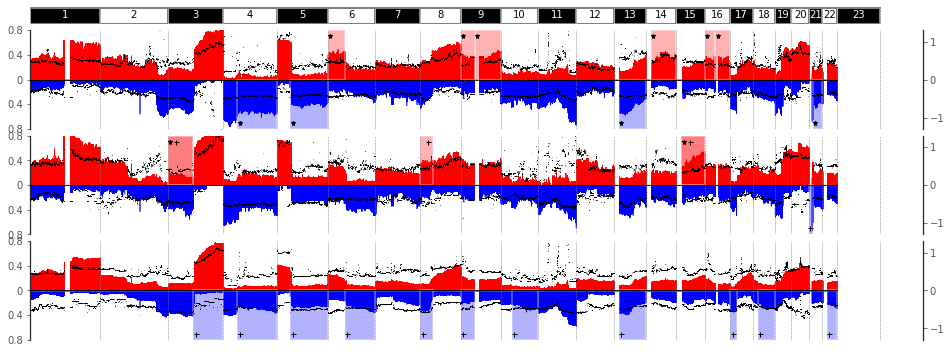

In [22]:
baseline = 0.8
fig = plt.figure(figsize=(16, 10), facecolor='white')
gs = gridspec.GridSpec(6, 1, height_ratios=[1, 6, 6, 6, 6, 6], 
                       hspace=0.08)  # vertical space

# plot chromosomes
ax0 = plt.subplot(gs[0], facecolor='white')
ax0.axis('off')
chrdf = chrdf.iloc[:23,:]

# figuring out xlim and ylim
for vl in vlns:
    _ = ax0.vlines(vl, 0, 1.6, color='white', linestyle='--', linewidth=.5)
xlims = (0, ax0.get_xlim()[1])
ylims = (0, ax0.get_ylim()[1])
_= ax0.set_xlim(xlims)
_ = ax0.set_ylim(ylims)
ylims = (0,1.6)

print(xlims, ylims)
plot_chromosomes(chrdf, ax0)


# # plot htmcp cnvs hiv+ 73 patients
ax1 = plt.subplot(gs[1], facecolor='white')
plot_frac_amplitude(ax1, htmcp_hiv_pos_recur_amps, htmcp_hiv_pos_recur_dels, num_htmcp_hiv_pos_patients)
plot_arms(hivpos_uniqamp_arms, arm_coords, ax1, 'amp', 'white', 9e6, '*')
plot_arms(hivpos_uniqdel_arms, arm_coords, ax1, 'del', 'white', 9e6, '*')

# # # plot htmcp cnvs hiv- 45 patients
ax2 = plt.subplot(gs[2], facecolor='white')
plot_frac_amplitude(ax2, htmcp_hiv_neg_recur_amps, htmcp_hiv_neg_recur_dels, num_htmcp_hiv_neg_patients)
plot_arms(hivneg_uniqamp_arms, arm_coords, ax2, 'amp', 'white', 9e6, '*')
plot_arms(hivneg2_uniqamp_arms, arm_coords, ax2, 'amp', 'white', 3e7, '+')
plot_arms(hivneg2_uniqdel_arms, arm_coords, ax2, 'del', 'white', 3e6, '+')

# plot tcga cnvs
ax3 = plt.subplot(gs[3], facecolor='white')
plot_frac_amplitude(ax3, tcga_amp, tcga_del, num_tcga_patients)
plot_arms(tcga_uniqdel_arms, arm_coords, ax3, 'del', 'white', 9e6,'+')

# plt.savefig(f'{wkdir}cnvs_publication_gistic_genes_thresholded.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'{wkdir}cnvs_publication_gistic_genes_thresholded_20190730.png', dpi=300, bbox_inches='tight')

In [90]:
# df[((df < -0.1) * df) > 0]
df.head(2)
# df[((df < -0.1) * df <0)].count(axis=1)

,TCGA-BI-A0VR-01A,TCGA-BI-A0VS-01A,TCGA-BI-A20A-01A,TCGA-C5-A0TN-01A,TCGA-C5-A1BE-01B,TCGA-C5-A1BF-01B,TCGA-C5-A1BI-01B,TCGA-C5-A1BJ-01A,TCGA-C5-A1BK-01B,TCGA-C5-A1BL-01A,...,TCGA-Q1-A6DT-01A,TCGA-Q1-A6DV-01A,TCGA-Q1-A6DW-01A,TCGA-Q1-A73O-01A,TCGA-Q1-A73P-01A,TCGA-Q1-A73Q-01A,TCGA-Q1-A73R-01A,TCGA-Q1-A73S-01A,TCGA-R2-A69V-01A,TCGA-RA-A741-01A
Chromosome Arm,,,,,,,,,,,,,,,,,,,,,
1p,0.212,0.125,0.0,0.0,0.0,0.00,0.149,0.717,0.397,0.000,...,0.0,0.0,0.751,0.0,0.0,0.000,0.000,0.0,0.226,0.0
1q,0.212,0.000,0.0,0.0,0.0,0.63,0.149,0.717,0.397,0.546,...,0.0,0.0,0.000,0.0,0.0,1.154,0.512,0.0,0.226,0.0


In [3]:
# deletion tcga vs hivneg
f = '/home/szong/bin/GISTIC_2_0_22/tcga/broad_values_by_arm.txt'
df = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df['avg'] = df[((df < -0.1) * df) < 0].mean(axis=1)
df['pct'] = (((df < -0.1) * df) < 0).sum(axis=1)/177
df = df[['avg', 'pct']].reset_index()


f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/broad_values_by_arm.txt'
df1 = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df1['avg'] = df1[((df1 < -0.1) * df1) < 0].mean(axis=1)
df1['pct'] = (((df1 < -0.1) * df1) < 0).sum(axis=1)/45
df1 = df1[['avg', 'pct']].reset_index()

dfm = pd.merge(df, df1, left_on='Chromosome Arm', right_on='Chromosome Arm')
dfm = dfm.set_index('Chromosome Arm')
dfm.columns = ['tcga_avg_amplitude', 'tcga_frequency', 'hivneg_avg_amplitude', 'hivneg_frequency']
f, ax = plt.subplots(figsize=(14, 7))
dfm.plot(marker='o', ax=ax, color=['red', 'red','blue','blue'])
_ = ax.set_title('arm level deletion: TCGA vs. HIV-')
_ = ax.set_ylabel('amplitude <------->  frequency')
_ = ax.set_xticks(range(39))
_ = ax.set_xticklabels(dfm.index)
# plt.savefig(f'{wkdir}HTMCP_cnv_arm_level_deletion_TCGA_vs_HIVneg.pdf', dpi=300, bbox_inches='tight')

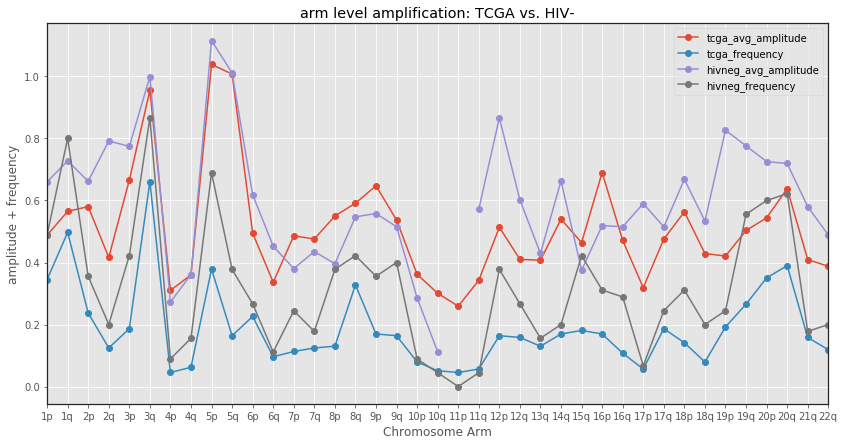

In [151]:
# amplification tacga vs hivneg
f = '/home/szong/bin/GISTIC_2_0_22/tcga/broad_values_by_arm.txt'
df = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df['avg'] = df[((df > 0.1) * df) > 0].mean(axis=1)
df['pct'] = (((df > 0.1) * df) > 0).sum(axis=1)/177
df = df[['avg', 'pct']].reset_index()


f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/broad_values_by_arm.txt'
df1 = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df1['avg'] = df1[((df1 >0.1) * df1) > 0].mean(axis=1)
df1['pct'] = (((df1 > 0.1) * df1) > 0).sum(axis=1)/45
df1 = df1[['avg', 'pct']].reset_index()

dfm = pd.merge(df, df1, left_on='Chromosome Arm', right_on='Chromosome Arm')
dfm = dfm.set_index('Chromosome Arm')
dfm.columns = ['tcga_avg_amplitude', 'tcga_frequency', 'hivneg_avg_amplitude', 'hivneg_frequency']
f, ax = plt.subplots(figsize=(14, 7))
dfm.plot(marker='o', ax=ax)#, color=['red', 'red','blue','blue'])
_ = ax.set_title('arm level amplification: TCGA vs. HIV-')
_ = ax.set_ylabel('amplitude + frequency')
_ = ax.set_xticks(range(39))
_ = ax.set_xticklabels(dfm.index)
plt.savefig(f'{wkdir}HTMCP_cnv_arm_level_amplification_TCGA_vs_HIVneg.pdf', dpi=300, bbox_inches='tight')

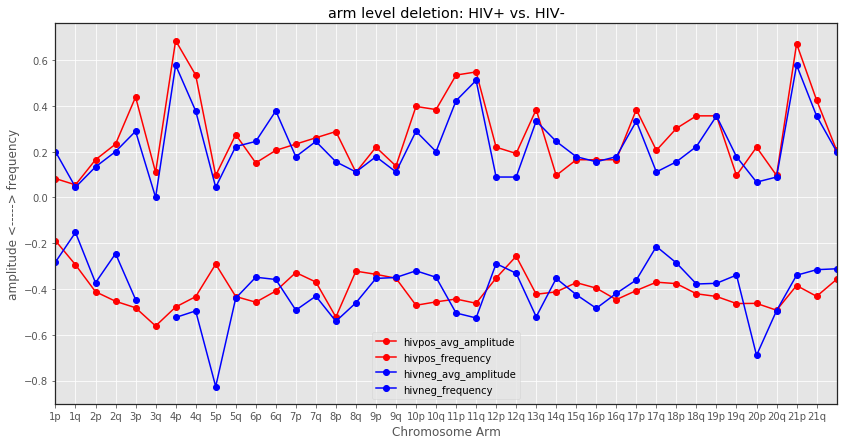

In [148]:
#deletion pos vs neg
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/broad_values_by_arm.txt'
df = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df['avg'] = df[((df < -0.1) * df) < 0].mean(axis=1)
df['pct'] = (((df < -0.1) * df) < 0).sum(axis=1)/73
df = df[['avg', 'pct']].reset_index()


f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/broad_values_by_arm.txt'
df1 = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df1['avg'] = df1[((df1 < -0.1) * df1) < 0].mean(axis=1)
df1['pct'] = (((df1 < -0.1) * df1) < 0).sum(axis=1)/45
df1 = df1[['avg', 'pct']].reset_index()

dfm = pd.merge(df, df1, left_on='Chromosome Arm', right_on='Chromosome Arm')
dfm = dfm.set_index('Chromosome Arm')
dfm.columns = ['hivpos_avg_amplitude', 'hivpos_frequency', 'hivneg_avg_amplitude', 'hivneg_frequency']
f, ax = plt.subplots(figsize=(14, 7))
dfm.plot(marker='o', ax=ax, color=['red', 'red','blue','blue'])
_ = ax.set_title('arm level deletion: HIV+ vs. HIV-')
_ = ax.set_ylabel('amplitude <-----> frequency')
_ = ax.set_xticks(range(39))
_ = ax.set_xticklabels(dfm.index)
plt.savefig(f'{wkdir}HTMCP_cnv_arm_level_deletion_HIVpos_vs_HIVneg.pdf', dpi=300, bbox_inches='tight')

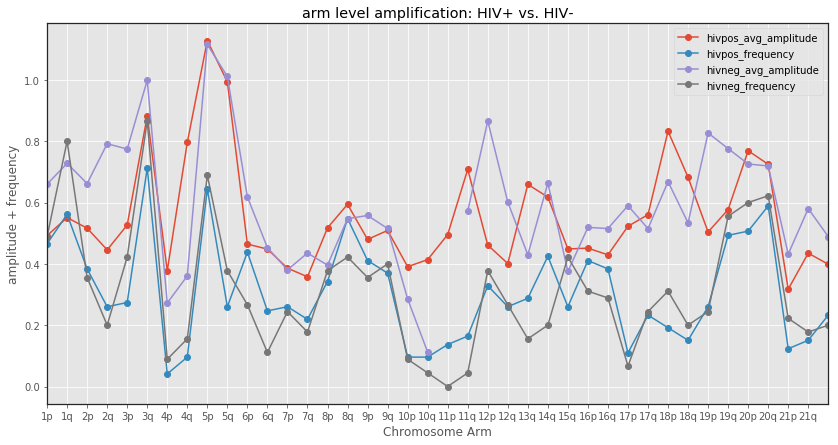

In [153]:
# amplification tacga vs hivneg
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/broad_values_by_arm.txt'
df = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df['avg'] = df[((df > 0.1) * df) > 0].mean(axis=1)
df['pct'] = (((df > 0.1) * df) > 0).sum(axis=1)/73
df = df[['avg', 'pct']].reset_index()


f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/broad_values_by_arm.txt'
df1 = pd.read_csv(f, sep='\t', index_col='Chromosome Arm')

df1['avg'] = df1[((df1 >0.1) * df1) > 0].mean(axis=1)
df1['pct'] = (((df1 > 0.1) * df1) > 0).sum(axis=1)/45
df1 = df1[['avg', 'pct']].reset_index()

dfm = pd.merge(df, df1, left_on='Chromosome Arm', right_on='Chromosome Arm')
dfm = dfm.set_index('Chromosome Arm')
dfm.columns = ['hivpos_avg_amplitude', 'hivpos_frequency', 'hivneg_avg_amplitude', 'hivneg_frequency']
f, ax = plt.subplots(figsize=(14, 7))
dfm.plot(marker='o', ax=ax)#, color=['red', 'red','blue','blue'])
_ = ax.set_title('arm level amplification: HIV+ vs. HIV-')
_ = ax.set_ylabel('amplitude + frequency')
_ = ax.set_xticks(range(39))
_ = ax.set_xticklabels(dfm.index)
plt.savefig(f'{wkdir}HTMCP_cnv_arm_level_amplification_HIVpos_vs_HIVneg.pdf', dpi=300, bbox_inches='tight')

# look at significant file

In [18]:
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/broad_significance_results.txt'
df = pd.read_csv(f, sep='\t', index_col='Arm')
df.head(8)
df.tail()

,# Genes,Amp frequency,Amp z-score,Amp q-value,Del Frequency,Del z-score,Del q-value
Arm,,,,,,,
1p,2121,0.50,3.630,8.120000e-04,0.17,-1.6800,0.997000
1q,1955,0.57,4.820,1.430000e-05,0.09,-2.6800,0.997000
2p,924,0.44,1.110,3.780000e-01,0.24,-1.8000,0.997000
2q,1556,0.32,-0.223,1.000000e+00,0.29,-0.6110,0.997000
3p,1062,0.41,0.667,5.610000e-01,0.60,3.7400,0.000744
3q,1139,0.78,7.250,8.320000e-12,0.36,0.0901,0.997000
4p,489,0.08,-3.110,1.000000e+00,0.69,5.1200,0.000003
4q,1049,0.17,-2.320,1.000000e+00,0.57,3.5400,0.001350


,# Genes,Amp frequency,Amp z-score,Amp q-value,Del Frequency,Del z-score,Del q-value
Arm,,,,,,,
20p,355,0.64,3.690,0.000742,0.46,0.725,6.690000e-01
20q,753,0.64,4.340,0.000071,0.23,-1.740,9.970000e-01
21p,13,0.35,-0.715,1.000000,0.77,5.680,2.700000e-07
21q,509,0.23,-2.140,1.000000,0.48,1.370,3.410000e-01
22q,921,0.27,-1.530,1.000000,0.25,-1.910,9.970000e-01


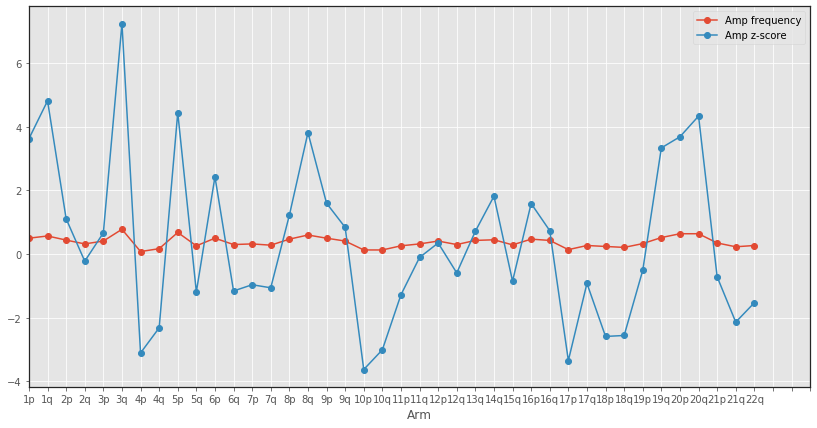

In [16]:
f, ax = plt.subplots(figsize=(14, 7))
df[['Amp frequency', 'Amp z-score']].plot(marker='o', ax=ax)
_ = ax.set_xticks(range(43))
_ = ax.set_xticklabels(df.index)